In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import json

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.corpus import wordnet as wn
from scipy.stats import linregress

In [74]:
#import nltk
#nltk.download('omw-1.4')

In [2]:
os.chdir("..")

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv("data/processed_dataset_final.csv",sep=';',index_col="index")

In [78]:
df

,sent_id,target,target_true,bm_0,bm_1,bm_2,bm_3,bm_4,bm_5,bm_6,...,wvc_294,wvc_295,wvc_296,wvc_297,wvc_298,wvc_299,freq_corr,freq_err_corr,freq_corr_corp,freq_err_corp
index,,,,,,,,,,,,,,,,,,,,,
1167,88.0,1,1,0.289653,0.659942,0.857995,0.456219,0.229857,0.317379,0.435600,...,-0.249210,-0.021673,-0.116785,-0.108414,0.161148,0.354648,1,1,1,5
1173,93.0,1,1,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,2,707,89
1174,93.0,0,0,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,2,707,864
1187,93.0,0,1,-0.112628,-0.088576,-0.228539,-0.125512,-0.287560,0.014738,-0.212544,...,0.207804,-0.022905,-0.255043,-0.053252,-0.093926,-0.076468,5,1,707,350
2332,171.0,0,1,-0.057980,0.168899,-0.199607,0.063531,-0.194752,-0.328900,0.319228,...,-0.033753,-0.761193,-0.044005,-0.092704,-0.432252,0.390534,39,13,4024,10015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695022,37399.0,0,1,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,2,1989,906
695024,37399.0,0,0,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,2,1989,325
695025,37399.0,0,0,0.182501,-0.010592,-0.631144,-0.054599,-0.031649,0.448475,0.056622,...,-0.082141,0.010859,-0.191100,-0.111232,-0.197992,0.006448,10,1,1989,2759


Построим корреляции между частотами и целевой переменной

In [79]:
df["freq_corr"].corr(df["target_true"])

-0.1650855063632987

In [80]:
df["freq_err_corr"].corr(df["target_true"])

0.16169958617027574

In [81]:
df["freq_corr_corp"].corr(df["target_true"])

-0.06811187035605024

In [82]:
df["freq_err_corp"].corr(df["target_true"])

0.06437693893720836

In [83]:
df[[
    "freq_corr",
    "freq_err_corr",
    "freq_corr_corp",
    "freq_err_corp"
]].corrwith(df["target_true"])

freq_corr        -0.165086
freq_err_corr     0.161700
freq_corr_corp   -0.068112
freq_err_corp     0.064377
dtype: float64

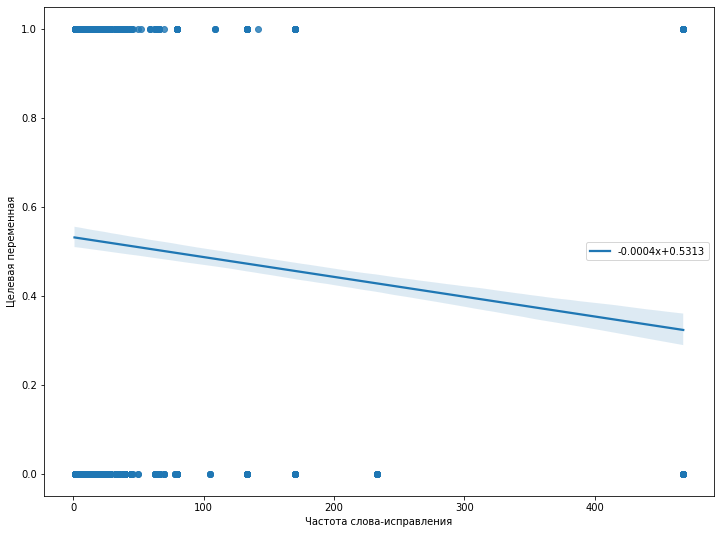

In [84]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = linregress(
    df["freq_corr"],
    df["target_true"]
)

plt.figure(figsize=[12,9])
ax = sns.regplot(
    x=df["freq_corr"],
    y=df["target_true"],
    line_kws={'label':"{0:.4f}x+{1:.4f}".format(slope,intercept)}
)
ax.legend()
plt.xlabel("Частота слова-исправления")
plt.ylabel("Целевая переменная")
plt.savefig(
    "freq_corr_target_correlation.png",
    bbox_inches="tight"
)

In [6]:
y = df["target"]
y1 = df["target_true"]
X = df.drop(["sent_id","target","target_true"], axis=1)

In [86]:
X.shape

(2837, 2140)

In [87]:
X.columns.tolist()

['bm_0',
 'bm_1',
 'bm_2',
 'bm_3',
 'bm_4',
 'bm_5',
 'bm_6',
 'bm_7',
 'bm_8',
 'bm_9',
 'bm_10',
 'bm_11',
 'bm_12',
 'bm_13',
 'bm_14',
 'bm_15',
 'bm_16',
 'bm_17',
 'bm_18',
 'bm_19',
 'bm_20',
 'bm_21',
 'bm_22',
 'bm_23',
 'bm_24',
 'bm_25',
 'bm_26',
 'bm_27',
 'bm_28',
 'bm_29',
 'bm_30',
 'bm_31',
 'bm_32',
 'bm_33',
 'bm_34',
 'bm_35',
 'bm_36',
 'bm_37',
 'bm_38',
 'bm_39',
 'bm_40',
 'bm_41',
 'bm_42',
 'bm_43',
 'bm_44',
 'bm_45',
 'bm_46',
 'bm_47',
 'bm_48',
 'bm_49',
 'bm_50',
 'bm_51',
 'bm_52',
 'bm_53',
 'bm_54',
 'bm_55',
 'bm_56',
 'bm_57',
 'bm_58',
 'bm_59',
 'bm_60',
 'bm_61',
 'bm_62',
 'bm_63',
 'bm_64',
 'bm_65',
 'bm_66',
 'bm_67',
 'bm_68',
 'bm_69',
 'bm_70',
 'bm_71',
 'bm_72',
 'bm_73',
 'bm_74',
 'bm_75',
 'bm_76',
 'bm_77',
 'bm_78',
 'bm_79',
 'bm_80',
 'bm_81',
 'bm_82',
 'bm_83',
 'bm_84',
 'bm_85',
 'bm_86',
 'bm_87',
 'bm_88',
 'bm_89',
 'bm_90',
 'bm_91',
 'bm_92',
 'bm_93',
 'bm_94',
 'bm_95',
 'bm_96',
 'bm_97',
 'bm_98',
 'bm_99',
 'bm_100',

In [7]:
with open("columns.json", 'w', encoding='utf-8') as outp:
    json.dump(X.columns.to_list(), outp)

In [8]:
def get_clfs_and_names():
    classifiers = [
        KNeighborsClassifier(n_neighbors=1),
        KNeighborsClassifier(n_neighbors=2),
        KNeighborsClassifier(n_neighbors=3),
        KNeighborsClassifier(n_neighbors=4),
        KNeighborsClassifier(n_neighbors=5),
        LinearSVC(random_state=42, max_iter=1000),
        DecisionTreeClassifier(random_state=42),
        LogisticRegression(random_state=42, max_iter=1000),
        RidgeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        GaussianNB(),
        XGBClassifier(random_state=42),
        LGBMClassifier(random_state=42),
        CatBoostClassifier(random_state=42)
    ]

    names = [type(clf).__name__ for clf in classifiers]

    return classifiers, names

Попробуем поделить на train и test не примеры, а предложения:

In [9]:
train_sents, test_sents = train_test_split(
    df["sent_id"].unique(),
    test_size=0.2,
    random_state=42
)

In [10]:
df_train = df.loc[
    df["sent_id"].isin(train_sents)
]
df_test = df.loc[
    df["sent_id"].isin(test_sents)
]

X_train, y_train = df_train.drop(
    ["target", "target_true", "sent_id"],
    axis=1
), df_train["target_true"]
X_test, y_test = df_test.drop(
    ["target", "target_true", "sent_id"],
    axis=1,
), df_test["target_true"]

y0_train = df_train["target"]
y0_test = df_test["target"]

In [11]:
len(y_test), len(y_train), len(X_test), len(X_train)

(641, 2196, 641, 2196)

Сначала пробуем на недоразмеченных данных:

In [127]:
classifiers, names = get_clfs_and_names()

result_df = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train, y0_train)

    y_train_pred = np.round(clf.predict(X_train))
    y_test_pred = np.round(clf.predict(X_test))

    train_f1 = f1_score(y0_train, y_train_pred)
    test_f1 = f1_score(y0_test, y_test_pred)

    train_acc = accuracy_score(y0_train, y_train_pred)
    test_acc = accuracy_score(y0_test, y_test_pred)

    train_precision = precision_score(y0_train, y_train_pred)
    test_precision = precision_score(y0_test, y_test_pred)

    train_recall = recall_score(y0_train, y_train_pred)
    test_recall = recall_score(y0_test, y_test_pred)

    result_df.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })

pd.DataFrame(result_df).sort_values(by=["test_f1"], ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_18820\2597223868.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6842113	total: 391ms	remaining: 6m 30s
1:	learn: 0.6742605	total: 627ms	remaining: 5m 12s
2:	learn: 0.6657595	total: 842ms	remaining: 4m 39s
3:	learn: 0.6567242	total: 1.04s	remaining: 4m 20s
4:	learn: 0.6488998	total: 1.25s	remaining: 4m 9s
5:	learn: 0.6409373	total: 1.46s	remaining: 4m 1s
6:	learn: 0.6329763	total: 1.66s	remaining: 3m 55s
7:	learn: 0.6258520	total: 1.87s	remaining: 3m 51s
8:	learn: 0.6186103	total: 2.07s	remaining: 3m 47s
9:	learn: 0.6105359	total: 2.27s	remaining: 3m 45s
10:	learn: 0.6039834	total: 2.48s	remaining: 3m 43s
11:	learn: 0.5977049	total: 2.69s	remaining: 3m 41s
12:	learn: 0.5915943	total: 2.89s	remaining: 3m 39s
13:	learn: 0.5852955	total: 3.1s	remaining: 3m 38s
14:	learn: 0.5797382	total: 3.31s	remaining: 3m 37s
15:	learn: 0.5741798	total: 3.51s	remaining: 3m 35s
16:	learn: 0.5686158	total: 3.71s	remaining: 3m 34s
17:	learn: 0.5629025	total: 3.92s	remaining: 3m 33s
18:	learn: 0.5575022	total: 4.12s	remaining: 3m

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
11,GradientBoostingClassifier,0.427807,0.766571,0.833073,0.926230,0.526316,0.988848,0.360360,0.625882
10,AdaBoostClassifier,0.420000,0.548105,0.819033,0.858834,0.471910,0.720307,0.378378,0.442353
14,XGBClassifier,0.395722,1.000000,0.823713,1.000000,0.486842,1.000000,0.333333,1.000000
13,GaussianNB,0.379009,0.432161,0.667707,0.639800,0.280172,0.310950,0.585586,0.708235
4,KNeighborsClassifier,0.375691,0.511905,0.823713,0.850638,0.485714,0.696356,0.306306,0.404706
16,CatBoostClassifier,0.373494,0.975904,0.837754,0.990893,0.563636,1.000000,0.279279,0.952941
6,DecisionTreeClassifier,0.370656,1.000000,0.745710,1.000000,0.324324,1.000000,0.432432,1.000000
12,HistGradientBoostingClassifier,0.369048,1.000000,0.834633,1.000000,0.543860,1.000000,0.279279,1.000000
8,RidgeClassifier,0.367816,0.770470,0.742590,0.922131,0.320000,0.896875,0.432432,0.675294
2,KNeighborsClassifier,0.357895,0.608321,0.809672,0.875683,0.430380,0.779412,0.306306,0.498824


Потом на доразмеченных:

In [110]:
classifiers, names = get_clfs_and_names()

result_df1 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train, y_train)

    y_train_pred = np.round(clf.predict(X_train))
    y_test_pred = np.round(clf.predict(X_test))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df1.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })

C:\Users\User\AppData\Local\Temp\ipykernel_18820\2236420017.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6899577	total: 258ms	remaining: 4m 17s
1:	learn: 0.6861072	total: 478ms	remaining: 3m 58s
2:	learn: 0.6825532	total: 702ms	remaining: 3m 53s
3:	learn: 0.6793017	total: 934ms	remaining: 3m 52s
4:	learn: 0.6754315	total: 1.15s	remaining: 3m 48s
5:	learn: 0.6715914	total: 1.37s	remaining: 3m 47s
6:	learn: 0.6673688	total: 1.59s	remaining: 3m 45s
7:	learn: 0.6644657	total: 1.81s	remaining: 3m 44s
8:	learn: 0.6612646	total: 2.02s	remaining: 3m 42s
9:	learn: 0.6570582	total: 2.24s	remaining: 3m 41s
10:	learn: 0.6532672	total: 2.47s	remaining: 3m 42s
11:	learn: 0.6503500	total: 2.69s	remaining: 3m 41s
12:	learn: 0.6476257	total: 2.9s	remaining: 3m 40s
13:	learn: 0.6449502	total: 3.12s	remaining: 3m 39s
14:	learn: 0.6428500	total: 3.33s	remaining: 3m 38s
15:	learn: 0.6400351	total: 3.55s	remaining: 3m 38s
16:	learn: 0.6376833	total: 3.77s	remaining: 3m 37s
17:	learn: 0.6350071	total: 3.99s	remaining: 3m 37s
18:	learn: 0.6323617	total: 4.21s	remaining: 

In [111]:
pd.DataFrame(result_df1).sort_values(by=["test_f1"],ascending=False)

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
14,XGBClassifier,0.718995,1.000000,0.720749,1.000000,0.689759,1.000000,0.750820,1.000000
11,GradientBoostingClassifier,0.714286,0.919687,0.719189,0.925319,0.692308,0.931548,0.737705,0.908124
16,CatBoostClassifier,0.712716,0.994678,0.714509,0.994991,0.683735,0.995160,0.744262,0.994197
9,RandomForestClassifier,0.706061,1.000000,0.697348,1.000000,0.656338,1.000000,0.763934,1.000000
15,LGBMClassifier,0.698113,1.000000,0.700468,1.000000,0.670695,1.000000,0.727869,1.000000
12,HistGradientBoostingClassifier,0.696734,1.000000,0.695788,1.000000,0.662722,1.000000,0.734426,1.000000
10,AdaBoostClassifier,0.686767,0.782904,0.708268,0.796448,0.702055,0.786341,0.672131,0.779497
7,LogisticRegression,0.685015,0.771550,0.678627,0.779144,0.641834,0.752066,0.734426,0.792070
0,KNeighborsClassifier,0.684976,1.000000,0.695788,1.000000,0.675159,1.000000,0.695082,1.000000
4,KNeighborsClassifier,0.680315,0.793741,0.683307,0.801913,0.654545,0.778605,0.708197,0.809478


Попробуем на одних частотах:

In [112]:
X_train1 = X_train[[
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
]]
X_test1 = X_test[[
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
]]

classifiers, names = get_clfs_and_names()

result_df2 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train1, y_train)

    y_train_pred = np.round(clf.predict(X_train1))
    y_test_pred = np.round(clf.predict(X_test1))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df2.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })

C:\Users\User\AppData\Local\Temp\ipykernel_18820\2813230522.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Timed out
Learning rate set to 0.014415
0:	learn: 0.6895258	total: 1.58ms	remaining: 1.58s
1:	learn: 0.6865476	total: 3.07ms	remaining: 1.53s
2:	learn: 0.6832007	total: 4.59ms	remaining: 1.52s
3:	learn: 0.6803422	total: 5.99ms	remaining: 1.49s
4:	learn: 0.6767883	total: 7.42ms	remaining: 1.48s
5:	learn: 0.6740140	total: 8.84ms	remaining: 1.46s
6:	learn: 0.6706441	total: 10.5ms	remaining: 1.49s
7:	learn: 0.6678024	total: 11.9ms	remaining: 1.47s
8:	learn: 0.6642079	total: 13.3ms	remaining: 1.47s
9:	learn: 0.6608993	total: 14.8ms	remaining: 1.46s
10:	learn: 0.6583683	total: 16.1ms	remaining: 1.45s
11:	learn: 0.6557507	total: 17.5ms	remaining: 1.44s
12:	learn: 0.6534228	total: 19ms	remaining: 1.44s
13:	learn: 0.6506157	total: 20.3ms	remaining: 1.43s
14:	learn: 0.6483272	total: 21.6ms	remaining: 1.42s
15:	learn: 0.6458322	total: 22.9ms	remaining: 1.41s
16:	learn: 0.6433243	total: 24.2ms	remaining: 1.4s
17:	learn: 0.6409198	total: 25.8ms	remaining: 1.41s
18:	learn: 0.6387095	total: 27ms	rema

In [113]:
pd.DataFrame(result_df2).sort_values(by=["test_f1"], ascending=False)

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
9,RandomForestClassifier,0.687919,0.858000,0.709828,0.870674,0.704467,0.888199,0.672131,0.829787
15,LGBMClassifier,0.687500,0.830095,0.703588,0.844718,0.689769,0.856115,0.685246,0.805609
14,XGBClassifier,0.682513,0.847716,0.708268,0.863388,0.707746,0.892094,0.659016,0.807544
12,HistGradientBoostingClassifier,0.682274,0.823821,0.703588,0.838342,0.696246,0.846075,0.668852,0.802708
2,KNeighborsClassifier,0.681115,0.784892,0.678627,0.787341,0.645161,0.749340,0.721311,0.823985
16,CatBoostClassifier,0.680921,0.790258,0.697348,0.807832,0.683168,0.812883,0.678689,0.768859
11,GradientBoostingClassifier,0.680851,0.733234,0.695788,0.755464,0.679739,0.753830,0.681967,0.713733
0,KNeighborsClassifier,0.672783,0.820513,0.666147,0.818306,0.630372,0.767031,0.721311,0.882012
10,AdaBoostClassifier,0.666667,0.684372,0.703588,0.718579,0.716981,0.725108,0.622951,0.647969
4,KNeighborsClassifier,0.662539,0.761417,0.659906,0.766849,0.627566,0.734712,0.701639,0.790135


Попробуем без частот:

In [114]:
X_train1 = X_train.drop([
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
], axis=1)
X_test1 = X_test.drop([
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
], axis=1)

classifiers, names = get_clfs_and_names()

result_df3 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train1, y_train)

    y_train_pred = np.round(clf.predict(X_train1))
    y_test_pred = np.round(clf.predict(X_test1))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df3.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })

C:\Users\User\AppData\Local\Temp\ipykernel_18820\4200198947.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

Flood control exceeded. Retry in 34.0 seconds
Flood control exceeded. Retry in 33.0 seconds
Flood control exceeded. Retry in 33.0 seconds


c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Flood control exceeded. Retry in 26.0 seconds
Flood control exceeded. Retry in 24.0 seconds
Flood control exceeded. Retry in 22.0 seconds
Flood control exceeded. Retry in 21.0 seconds
Flood control exceeded. Retry in 17.0 seconds
Timed out
Learning rate set to 0.014415
0:	learn: 0.6883157	total: 236ms	remaining: 3m 56s
1:	learn: 0.6843094	total: 451ms	remaining: 3m 45s
2:	learn: 0.6807621	total: 656ms	remaining: 3m 38s
3:	learn: 0.6775071	total: 856ms	remaining: 3m 33s
4:	learn: 0.6735267	total: 1.06s	remaining: 3m 31s
5:	learn: 0.6693692	total: 1.27s	remaining: 3m 30s
6:	learn: 0.6666885	total: 1.48s	remaining: 3m 29s
7:	learn: 0.6633389	total: 1.68s	remaining: 3m 28s
8:	learn: 0.6597938	total: 1.88s	remaining: 3m 27s
9:	learn: 0.6562094	total: 2.09s	remaining: 3m 27s
10:	learn: 0.6534068	total: 2.3s	remaining: 3m 26s
11:	learn: 0.6507970	total: 2.5s	remaining: 3m 26s
12:	learn: 0.6487412	total: 2.71s	remaining: 3m 25s
13:	learn: 0.6463601	total: 2.92s	remaining: 3m 25s
14:	learn: 0.6

In [115]:
pd.DataFrame(result_df3).sort_values(by=["test_f1"], ascending=False)

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
16,CatBoostClassifier,0.721362,0.993230,0.719189,0.993625,0.683284,0.993230,0.763934,0.993230
12,HistGradientBoostingClassifier,0.703822,1.000000,0.709828,1.000000,0.684211,1.000000,0.724590,1.000000
14,XGBClassifier,0.698908,1.000000,0.698908,1.000000,0.666667,1.000000,0.734426,1.000000
15,LGBMClassifier,0.698113,1.000000,0.700468,1.000000,0.670695,1.000000,0.727869,1.000000
9,RandomForestClassifier,0.692427,1.000000,0.689548,1.000000,0.654971,1.000000,0.734426,1.000000
11,GradientBoostingClassifier,0.684375,0.922622,0.684867,0.928506,0.653731,0.940704,0.718033,0.905222
4,KNeighborsClassifier,0.681319,0.715658,0.683307,0.730419,0.653614,0.710878,0.711475,0.720503
2,KNeighborsClassifier,0.671803,0.777985,0.667707,0.783242,0.633721,0.751351,0.714754,0.806576
7,LogisticRegression,0.661562,0.874755,0.655226,0.883424,0.620690,0.885149,0.708197,0.864603
0,KNeighborsClassifier,0.659128,1.000000,0.670827,1.000000,0.649682,1.000000,0.668852,1.000000


Снова попробуем выбрасывать признаки по одному:

In [130]:
result_df4 = []

for feat in tqdm_notebook(feats, total=len(feats)):
    classifiers, names = get_clfs_and_names()

    X_train1 = X_train[[col for col in X_train.columns if not col.startswith(feat)]]
    X_test1 = X_test[[col for col in X_test.columns if not col.startswith(feat)]]

    for name, clf in zip(names, classifiers):
        # try:
            clf.fit(X_train1, y_train)

            y_train_pred = np.round(clf.predict(X_train1))
            y_test_pred = np.round(clf.predict(X_test1))

            train_f1 = f1_score(y_train, y_train_pred)
            test_f1 = f1_score(y_test, y_test_pred)

            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            train_precision = precision_score(y_train, y_train_pred)
            test_precision = precision_score(y_test, y_test_pred)

            train_recall = recall_score(y_train, y_train_pred)
            test_recall = recall_score(y_test, y_test_pred)

            result_df4.append({
                "feature_dropped": feat,
                "name": name,
                "test_f1": test_f1,
                "train_f1": train_f1,
                "test_acc": test_acc,
                "train_acc": train_acc,
                "test_precision": test_precision,
                "train_precision": train_precision,
                "test_recall": test_recall,
                "train_recall": train_recall
            })

C:\Users\User\AppData\Local\Temp\ipykernel_18820\1688994882.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for feat in tqdm_notebook(feats, total=len(feats)):


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6877930	total: 212ms	remaining: 3m 31s
1:	learn: 0.6839550	total: 356ms	remaining: 2m 57s
2:	learn: 0.6794620	total: 523ms	remaining: 2m 53s
3:	learn: 0.6764223	total: 661ms	remaining: 2m 44s
4:	learn: 0.6723369	total: 794ms	remaining: 2m 37s
5:	learn: 0.6684400	total: 938ms	remaining: 2m 35s
6:	learn: 0.6652960	total: 1.07s	remaining: 2m 32s
7:	learn: 0.6621614	total: 1.21s	remaining: 2m 30s
8:	learn: 0.6591805	total: 1.35s	remaining: 2m 28s
9:	learn: 0.6559614	total: 1.49s	remaining: 2m 27s
10:	learn: 0.6531000	total: 1.64s	remaining: 2m 27s
11:	learn: 0.6497763	total: 1.78s	remaining: 2m 26s
12:	learn: 0.6470107	total: 1.93s	remaining: 2m 26s
13:	learn: 0.6441997	total: 2.07s	remaining: 2m 25s
14:	learn: 0.6418566	total: 2.21s	remaining: 2m 25s
15:	learn: 0.6389334	total: 2.35s	remaining: 2m 24s
16:	learn: 0.6359299	total: 2.52s	remaining: 2m 25s
17:	learn: 0.6331623	total: 2.68s	remaining: 2m 26s
18:	learn: 0.6309602	total: 2.81s	remaining:

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6895905	total: 209ms	remaining: 3m 28s
1:	learn: 0.6853986	total: 399ms	remaining: 3m 19s
2:	learn: 0.6811346	total: 588ms	remaining: 3m 15s
3:	learn: 0.6777428	total: 771ms	remaining: 3m 12s
4:	learn: 0.6743187	total: 956ms	remaining: 3m 10s
5:	learn: 0.6706569	total: 1.13s	remaining: 3m 7s
6:	learn: 0.6676443	total: 1.32s	remaining: 3m 7s
7:	learn: 0.6642849	total: 1.5s	remaining: 3m 6s
8:	learn: 0.6613035	total: 1.7s	remaining: 3m 6s
9:	learn: 0.6582429	total: 1.87s	remaining: 3m 5s
10:	learn: 0.6553908	total: 2.05s	remaining: 3m 4s
11:	learn: 0.6523948	total: 2.23s	remaining: 3m 3s
12:	learn: 0.6495172	total: 2.42s	remaining: 3m 3s
13:	learn: 0.6472625	total: 2.6s	remaining: 3m 3s
14:	learn: 0.6435950	total: 2.78s	remaining: 3m 2s
15:	learn: 0.6403236	total: 2.96s	remaining: 3m 2s
16:	learn: 0.6377447	total: 3.15s	remaining: 3m 1s
17:	learn: 0.6351513	total: 3.33s	remaining: 3m 1s
18:	learn: 0.6329328	total: 3.52s	remaining: 3m 1s
19:	learn

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6902579	total: 204ms	remaining: 3m 24s
1:	learn: 0.6875551	total: 391ms	remaining: 3m 15s
2:	learn: 0.6845706	total: 580ms	remaining: 3m 12s
3:	learn: 0.6822303	total: 762ms	remaining: 3m 9s
4:	learn: 0.6789172	total: 951ms	remaining: 3m 9s
5:	learn: 0.6762040	total: 1.14s	remaining: 3m 8s
6:	learn: 0.6737459	total: 1.32s	remaining: 3m 7s
7:	learn: 0.6713633	total: 1.5s	remaining: 3m 6s
8:	learn: 0.6690907	total: 1.69s	remaining: 3m 5s
9:	learn: 0.6662006	total: 1.88s	remaining: 3m 5s
10:	learn: 0.6640712	total: 2.06s	remaining: 3m 5s
11:	learn: 0.6616364	total: 2.24s	remaining: 3m 4s
12:	learn: 0.6597341	total: 2.42s	remaining: 3m 4s
13:	learn: 0.6577854	total: 2.6s	remaining: 3m 3s
14:	learn: 0.6560439	total: 2.79s	remaining: 3m 3s
15:	learn: 0.6540063	total: 2.98s	remaining: 3m 3s
16:	learn: 0.6519523	total: 3.16s	remaining: 3m 2s
17:	learn: 0.6502634	total: 3.34s	remaining: 3m 2s
18:	learn: 0.6484205	total: 3.52s	remaining: 3m 1s
19:	learn:

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6891437	total: 231ms	remaining: 3m 51s
1:	learn: 0.6850851	total: 457ms	remaining: 3m 48s
2:	learn: 0.6810548	total: 675ms	remaining: 3m 44s
3:	learn: 0.6771728	total: 898ms	remaining: 3m 43s
4:	learn: 0.6728698	total: 1.12s	remaining: 3m 42s
5:	learn: 0.6696508	total: 1.33s	remaining: 3m 40s
6:	learn: 0.6665651	total: 1.55s	remaining: 3m 40s
7:	learn: 0.6634130	total: 1.77s	remaining: 3m 39s
8:	learn: 0.6608501	total: 2s	remaining: 3m 40s
9:	learn: 0.6570002	total: 2.21s	remaining: 3m 39s
10:	learn: 0.6545653	total: 2.44s	remaining: 3m 39s
11:	learn: 0.6522800	total: 2.65s	remaining: 3m 37s
12:	learn: 0.6494929	total: 2.88s	remaining: 3m 38s
13:	learn: 0.6473402	total: 3.1s	remaining: 3m 38s
14:	learn: 0.6439254	total: 3.34s	remaining: 3m 39s
15:	learn: 0.6409910	total: 3.55s	remaining: 3m 38s
16:	learn: 0.6384436	total: 3.77s	remaining: 3m 38s
17:	learn: 0.6356466	total: 3.99s	remaining: 3m 37s
18:	learn: 0.6332573	total: 4.2s	remaining: 3m 3

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 252ms	remaining: 4m 11s
1:	learn: 0.6860773	total: 467ms	remaining: 3m 53s
2:	learn: 0.6821155	total: 683ms	remaining: 3m 46s
3:	learn: 0.6787994	total: 898ms	remaining: 3m 43s
4:	learn: 0.6750070	total: 1.11s	remaining: 3m 41s
5:	learn: 0.6721168	total: 1.33s	remaining: 3m 40s
6:	learn: 0.6688847	total: 1.54s	remaining: 3m 38s
7:	learn: 0.6655003	total: 1.76s	remaining: 3m 38s
8:	learn: 0.6619188	total: 1.98s	remaining: 3m 37s
9:	learn: 0.6588473	total: 2.19s	remaining: 3m 36s
10:	learn: 0.6564627	total: 2.4s	remaining: 3m 36s
11:	learn: 0.6540980	total: 2.62s	remaining: 3m 35s
12:	learn: 0.6517999	total: 2.84s	remaining: 3m 35s
13:	learn: 0.6488198	total: 3.05s	remaining: 3m 34s
14:	learn: 0.6467977	total: 3.27s	remaining: 3m 34s
15:	learn: 0.6444910	total: 3.48s	remaining: 3m 34s
16:	learn: 0.6421801	total: 3.69s	remaining: 3m 33s
17:	learn: 0.6390492	total: 3.91s	remaining: 3m 33s
18:	learn: 0.6367545	total: 4.11s	remaining: 

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 250ms	remaining: 4m 10s
1:	learn: 0.6860773	total: 463ms	remaining: 3m 50s
2:	learn: 0.6821155	total: 674ms	remaining: 3m 43s
3:	learn: 0.6786332	total: 888ms	remaining: 3m 41s
4:	learn: 0.6751909	total: 1.1s	remaining: 3m 38s
5:	learn: 0.6722836	total: 1.31s	remaining: 3m 37s
6:	learn: 0.6691779	total: 1.52s	remaining: 3m 35s
7:	learn: 0.6660066	total: 1.74s	remaining: 3m 35s
8:	learn: 0.6630888	total: 1.95s	remaining: 3m 34s
9:	learn: 0.6601828	total: 2.16s	remaining: 3m 34s
10:	learn: 0.6576485	total: 2.37s	remaining: 3m 33s
11:	learn: 0.6554048	total: 2.58s	remaining: 3m 32s
12:	learn: 0.6526013	total: 2.79s	remaining: 3m 32s
13:	learn: 0.6502295	total: 3s	remaining: 3m 31s
14:	learn: 0.6476616	total: 3.21s	remaining: 3m 31s
15:	learn: 0.6453315	total: 3.43s	remaining: 3m 31s
16:	learn: 0.6427631	total: 3.64s	remaining: 3m 30s
17:	learn: 0.6402745	total: 3.85s	remaining: 3m 30s
18:	learn: 0.6379491	total: 4.06s	remaining: 3m 

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 241ms	remaining: 4m 1s
1:	learn: 0.6858498	total: 458ms	remaining: 3m 48s
2:	learn: 0.6818874	total: 670ms	remaining: 3m 42s
3:	learn: 0.6784070	total: 885ms	remaining: 3m 40s
4:	learn: 0.6757444	total: 1.1s	remaining: 3m 38s
5:	learn: 0.6728482	total: 1.32s	remaining: 3m 38s
6:	learn: 0.6697496	total: 1.53s	remaining: 3m 37s
7:	learn: 0.6673030	total: 1.75s	remaining: 3m 36s
8:	learn: 0.6636635	total: 1.96s	remaining: 3m 35s
9:	learn: 0.6603763	total: 2.17s	remaining: 3m 34s
10:	learn: 0.6578576	total: 2.38s	remaining: 3m 34s
11:	learn: 0.6554707	total: 2.59s	remaining: 3m 33s
12:	learn: 0.6532151	total: 2.8s	remaining: 3m 32s
13:	learn: 0.6502182	total: 3.02s	remaining: 3m 32s
14:	learn: 0.6476198	total: 3.23s	remaining: 3m 32s
15:	learn: 0.6450913	total: 3.45s	remaining: 3m 32s
16:	learn: 0.6428783	total: 3.67s	remaining: 3m 32s
17:	learn: 0.6404000	total: 3.88s	remaining: 3m 31s
18:	learn: 0.6380682	total: 4.1s	remaining: 3m 

In [131]:
pd.DataFrame(result_df4).sort_values(by=["test_f1"],ascending=False)

,feature_dropped,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
33,wvc,CatBoostClassifier,0.725832,0.994678,0.730109,0.994991,0.702454,0.995160,0.750820,0.994197
94,freq_corr_corp,RandomForestClassifier,0.720000,1.000000,0.716069,1.000000,0.678261,1.000000,0.767213,1.000000
26,wvc,RandomForestClassifier,0.718750,1.000000,0.719189,1.000000,0.686567,1.000000,0.754098,1.000000
32,wvc,LGBMClassifier,0.716745,1.000000,0.717629,1.000000,0.685629,1.000000,0.750820,1.000000
77,freq_err_corr,RandomForestClassifier,0.716279,1.000000,0.714509,1.000000,0.679412,1.000000,0.757377,1.000000
...,...,...,...,...,...,...,...,...,...,...
42,wve,RidgeClassifier,0.546341,0.711297,0.564743,0.748634,0.541935,0.774487,0.550820,0.657640
90,freq_corr_corp,LinearSVC,0.352657,0.462203,0.581903,0.659836,0.669725,0.904225,0.239344,0.310445
39,wve,LinearSVC,0.327628,0.355522,0.570983,0.612022,0.644231,0.815972,0.219672,0.227273
107,freq_err_corp,LinearSVC,0.311111,0.437946,0.564743,0.641166,0.630000,0.834239,0.206557,0.296905


In [135]:
os.mkdir("results_sent_split_no_scaling")

In [18]:
def rename_knns(l: list):
    new_names = [
        f"{i+1}NeighborClassifier" for i in range(5)
    ]
    for item in l:
        if item["name"] in ("KNeighborsClassifier", "{i+1}NeighborClassifier"):
            item["name"] = new_names.pop(0)
            if not len(new_names):
                new_names = [
                    f"{i+1}NeighborClassifier" for i in range(5)
                ]
    return l

In [166]:
dfs = [
    pd.DataFrame(rename_knns(result_df)),
    pd.DataFrame(rename_knns(result_df1)),
    pd.DataFrame(rename_knns(result_df2)),
    pd.DataFrame(rename_knns(result_df3)),
    pd.DataFrame(rename_knns(result_df4))
]

df_names = [
    "all_features_target_orig",
    "all_features",
    "only_freqs",
    "only_vectors",
    "feature_drop",
]

In [167]:
dfs[0]

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
0,1NeighborClassifier,0.352941,1.000000,0.759750,1.000000,0.330709,1.000000,0.378378,1.000000
1,2NeighborClassifier,0.293333,0.462929,0.834633,0.864754,0.564103,1.000000,0.198198,0.301176
2,3NeighborClassifier,0.357895,0.608321,0.809672,0.875683,0.430380,0.779412,0.306306,0.498824
3,4NeighborClassifier,0.259740,0.407080,0.822153,0.847450,0.465116,0.821429,0.180180,0.270588
4,5NeighborClassifier,0.375691,0.511905,0.823713,0.850638,0.485714,0.696356,0.306306,0.404706
5,LinearSVC,0.337793,0.396761,0.382215,0.457195,0.207392,0.252740,0.909910,0.922353
6,DecisionTreeClassifier,0.370656,1.000000,0.745710,1.000000,0.324324,1.000000,0.432432,1.000000
7,LogisticRegression,0.331492,0.535385,0.811232,0.862477,0.428571,0.773333,0.270270,0.409412
8,RidgeClassifier,0.367816,0.770470,0.742590,0.922131,0.320000,0.896875,0.432432,0.675294
9,RandomForestClassifier,0.244604,1.000000,0.836193,1.000000,0.607143,1.000000,0.153153,1.000000


In [170]:
for df, df_name in zip(dfs, df_names):
    df = df.sort_values(by=["test_f1"], ascending=False)
    df.to_excel(
        f"results_sent_split_no_scaling/{df_name}.xlsx",
        float_format="%.4f"
    )

Попробуем со скейлингом:

In [20]:
scaler = StandardScaler().fit(X_train)
X_train1 = scaler.transform(X_train)
X_test1 = scaler.transform(X_test)


classifiers, names = get_clfs_and_names()

result_df5 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train1, y_train)

    y_train_pred = np.round(clf.predict(X_train1))
    y_test_pred = np.round(clf.predict(X_test1))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df5.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })
    try:
        print(f"{name}, test score {str(test_f1)}, train score {str(train_f1)}")
    except Exception as e:
        print(e)
    # except Exception as exc:
    #     bot.send_message(str(exc))

C:\Users\User\AppData\Local\Temp\ipykernel_1500\3610128569.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6899577	total: 241ms	remaining: 4m
1:	learn: 0.6861072	total: 453ms	remaining: 3m 46s
2:	learn: 0.6825532	total: 670ms	remaining: 3m 42s
3:	learn: 0.6793017	total: 890ms	remaining: 3m 41s
4:	learn: 0.6754315	total: 1.1s	remaining: 3m 39s
5:	learn: 0.6715914	total: 1.32s	remaining: 3m 38s
6:	learn: 0.6673688	total: 1.53s	remaining: 3m 37s
7:	learn: 0.6644657	total: 1.74s	remaining: 3m 35s
8:	learn: 0.6612646	total: 1.95s	remaining: 3m 34s
9:	learn: 0.6570582	total: 2.16s	remaining: 3m 34s
10:	learn: 0.6532672	total: 2.38s	remaining: 3m 33s
11:	learn: 0.6503500	total: 2.59s	remaining: 3m 33s
12:	learn: 0.6476257	total: 2.83s	remaining: 3m 34s
13:	learn: 0.6449502	total: 3.03s	remaining: 3m 33s
14:	learn: 0.6428500	total: 3.24s	remaining: 3m 33s
15:	learn: 0.6400351	total: 3.45s	remaining: 3m 32s
16:	learn: 0.6376833	total: 3.66s	remaining: 3m 31s
17:	learn: 0.6350071	total: 3.87s	remaining: 3m 31s
18:	learn: 0.6323617	total: 4.1s	remaining: 3m 31

In [159]:
pd.DataFrame(rename_knns(result_df5)).sort_values(by=["test_f1"],ascending=False)

,name,test_f1,train_f1,test_acc,train_acc,test_precision,train_precision,test_recall,train_recall
14,XGBClassifier,0.718995,1.000000,0.720749,1.000000,0.689759,1.000000,0.750820,1.000000
11,GradientBoostingClassifier,0.714286,0.919687,0.719189,0.925319,0.692308,0.931548,0.737705,0.908124
16,CatBoostClassifier,0.712716,0.994678,0.714509,0.994991,0.683735,0.995160,0.744262,0.994197
15,LGBMClassifier,0.706250,1.000000,0.706708,1.000000,0.674627,1.000000,0.740984,1.000000
9,RandomForestClassifier,0.706061,1.000000,0.697348,1.000000,0.656338,1.000000,0.763934,1.000000
12,HistGradientBoostingClassifier,0.696734,1.000000,0.695788,1.000000,0.662722,1.000000,0.734426,1.000000
10,AdaBoostClassifier,0.686767,0.782904,0.708268,0.796448,0.702055,0.786341,0.672131,0.779497
2,3NeighborClassifier,0.668740,0.788301,0.667707,0.792350,0.636095,0.758036,0.704918,0.821083
4,5NeighborClassifier,0.663462,0.728160,0.672387,0.746357,0.648903,0.734975,0.678689,0.721470
0,1NeighborClassifier,0.644951,1.000000,0.659906,1.000000,0.640777,1.000000,0.649180,1.000000


In [16]:
s = StandardScaler()
X_train11 = s.fit_transform(X_train[[
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
]])
X_test11 = s.transform(X_test[[
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
]])

classifiers, names = get_clfs_and_names()

result_df6 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train11, y_train)

    y_train_pred = np.round(clf.predict(X_train11))
    y_test_pred = np.round(clf.predict(X_test11))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df6.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })

s = StandardScaler()
X_train11 = s.fit_transform(X_train.drop([
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
], axis=1))
X_test11 = s.transform(X_test.drop([
    "freq_err_corp","freq_err_corr","freq_corr","freq_corr_corp"
], axis=1))

classifiers, names = get_clfs_and_names()

result_df7 = []

for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):
    # try:
    clf.fit(X_train11, y_train)

    y_train_pred = np.round(clf.predict(X_train11))
    y_test_pred = np.round(clf.predict(X_test11))

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    result_df7.append({
        "name": name,
        "test_f1": test_f1,
        "train_f1": train_f1,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "test_precision": test_precision,
        "train_precision": train_precision,
        "test_recall": test_recall,
        "train_recall": train_recall
    })


C:\Users\User\AppData\Local\Temp\ipykernel_1500\2103495487.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6895258	total: 175ms	remaining: 2m 55s
1:	learn: 0.6865476	total: 188ms	remaining: 1m 33s
2:	learn: 0.6832007	total: 194ms	remaining: 1m 4s
3:	learn: 0.6803422	total: 200ms	remaining: 49.9s
4:	learn: 0.6767883	total: 205ms	remaining: 40.8s
5:	learn: 0.6740140	total: 208ms	remaining: 34.5s
6:	learn: 0.6706441	total: 211ms	remaining: 29.9s
7:	learn: 0.6678024	total: 214ms	remaining: 26.5s
8:	learn: 0.6642079	total: 216ms	remaining: 23.8s
9:	learn: 0.6608993	total: 219ms	remaining: 21.7s
10:	learn: 0.6583683	total: 221ms	remaining: 19.8s
11:	learn: 0.6557507	total: 223ms	remaining: 18.3s
12:	learn: 0.6534228	total: 225ms	remaining: 17.1s
13:	learn: 0.6506157	total: 227ms	remaining: 16s
14:	learn: 0.6483272	total: 229ms	remaining: 15.1s
15:	learn: 0.6458322	total: 231ms	remaining: 14.2s
16:	learn: 0.6433243	total: 233ms	remaining: 13.5s
17:	learn: 0.6409198	total: 234ms	remaining: 12.8s
18:	learn: 0.6387095	total: 236ms	remaining: 12.2s
19:	learn: 

C:\Users\User\AppData\Local\Temp\ipykernel_1500\2103495487.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name, clf in tqdm_notebook(zip(names, classifiers), total=len(names)):


  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6883157	total: 292ms	remaining: 4m 51s
1:	learn: 0.6843094	total: 507ms	remaining: 4m 13s
2:	learn: 0.6807621	total: 728ms	remaining: 4m 1s
3:	learn: 0.6775071	total: 943ms	remaining: 3m 54s
4:	learn: 0.6735267	total: 1.16s	remaining: 3m 50s
5:	learn: 0.6693692	total: 1.37s	remaining: 3m 47s
6:	learn: 0.6666885	total: 1.58s	remaining: 3m 44s
7:	learn: 0.6633389	total: 1.79s	remaining: 3m 41s
8:	learn: 0.6597938	total: 2s	remaining: 3m 40s
9:	learn: 0.6562094	total: 2.21s	remaining: 3m 38s
10:	learn: 0.6534068	total: 2.42s	remaining: 3m 37s
11:	learn: 0.6507970	total: 2.62s	remaining: 3m 35s
12:	learn: 0.6487412	total: 2.87s	remaining: 3m 37s
13:	learn: 0.6463601	total: 3.07s	remaining: 3m 36s
14:	learn: 0.6437416	total: 3.28s	remaining: 3m 35s
15:	learn: 0.6413600	total: 3.49s	remaining: 3m 34s
16:	learn: 0.6391060	total: 3.7s	remaining: 3m 34s
17:	learn: 0.6373321	total: 3.91s	remaining: 3m 33s
18:	learn: 0.6345117	total: 4.12s	remaining: 3m 3

In [171]:
os.mkdir("results_sent_split_with_scaling")

In [21]:
dfs = [
    pd.DataFrame(rename_knns(result_df5)),
    pd.DataFrame(rename_knns(result_df6)),
    pd.DataFrame(rename_knns(result_df7))
]

df_names = [
    "all_features",
    "freqs_only",
    "vectors_only"
]

for df, df_name in zip(dfs, df_names):
    df = df.sort_values(by=["test_f1"], ascending=False)
    df.to_excel(
        f"results_sent_split_with_scaling/{df_name}.xlsx",
        float_format="%.4f"
    )

Снова попробуем выбрасывать признаки по одному:

In [22]:
result_df8 = []

for feat in tqdm_notebook(feats, total=len(feats)):
    classifiers, names = get_clfs_and_names()

    scaler = StandardScaler()

    X_train1 = scaler.fit_transform(
        X_train[[col for col in X_train.columns if not col.startswith(feat)]]
    )
    X_test1 = scaler.transform(X_test[[col for col in X_test.columns if not col.startswith(feat)]])

    for name, clf in zip(names, classifiers):
        # try:
            clf.fit(X_train1, y_train)

            y_train_pred = np.round(clf.predict(X_train1))
            y_test_pred = np.round(clf.predict(X_test1))

            train_f1 = f1_score(y_train, y_train_pred)
            test_f1 = f1_score(y_test, y_test_pred)

            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            train_precision = precision_score(y_train, y_train_pred)
            test_precision = precision_score(y_test, y_test_pred)

            train_recall = recall_score(y_train, y_train_pred)
            test_recall = recall_score(y_test, y_test_pred)

            result_df8.append({
                "feature_dropped": feat,
                "name": name,
                "test_f1": test_f1,
                "train_f1": train_f1,
                "test_acc": test_acc,
                "train_acc": train_acc,
                "test_precision": test_precision,
                "train_precision": train_precision,
                "test_recall": test_recall,
                "train_recall": train_recall
            })

C:\Users\User\AppData\Local\Temp\ipykernel_1500\1843835807.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for feat in tqdm_notebook(feats, total=len(feats)):


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6877930	total: 218ms	remaining: 3m 37s
1:	learn: 0.6839550	total: 364ms	remaining: 3m 1s
2:	learn: 0.6794620	total: 505ms	remaining: 2m 47s
3:	learn: 0.6764223	total: 641ms	remaining: 2m 39s
4:	learn: 0.6723369	total: 778ms	remaining: 2m 34s
5:	learn: 0.6684400	total: 912ms	remaining: 2m 31s
6:	learn: 0.6652960	total: 1.05s	remaining: 2m 29s
7:	learn: 0.6621614	total: 1.19s	remaining: 2m 27s
8:	learn: 0.6591805	total: 1.32s	remaining: 2m 25s
9:	learn: 0.6559614	total: 1.47s	remaining: 2m 25s
10:	learn: 0.6531000	total: 1.6s	remaining: 2m 23s
11:	learn: 0.6497763	total: 1.74s	remaining: 2m 23s
12:	learn: 0.6470107	total: 1.88s	remaining: 2m 22s
13:	learn: 0.6441997	total: 2.01s	remaining: 2m 21s
14:	learn: 0.6418566	total: 2.15s	remaining: 2m 21s
15:	learn: 0.6389334	total: 2.29s	remaining: 2m 20s
16:	learn: 0.6359299	total: 2.43s	remaining: 2m 20s
17:	learn: 0.6331623	total: 2.57s	remaining: 2m 20s
18:	learn: 0.6309602	total: 2.71s	remaining: 2

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6895905	total: 220ms	remaining: 3m 40s
1:	learn: 0.6853986	total: 407ms	remaining: 3m 23s
2:	learn: 0.6811346	total: 589ms	remaining: 3m 15s
3:	learn: 0.6777428	total: 764ms	remaining: 3m 10s
4:	learn: 0.6743187	total: 953ms	remaining: 3m 9s
5:	learn: 0.6706569	total: 1.13s	remaining: 3m 7s
6:	learn: 0.6676443	total: 1.32s	remaining: 3m 7s
7:	learn: 0.6642849	total: 1.5s	remaining: 3m 5s
8:	learn: 0.6613035	total: 1.69s	remaining: 3m 5s
9:	learn: 0.6582429	total: 1.87s	remaining: 3m 5s
10:	learn: 0.6553908	total: 2.06s	remaining: 3m 4s
11:	learn: 0.6523948	total: 2.24s	remaining: 3m 4s
12:	learn: 0.6495172	total: 2.43s	remaining: 3m 4s
13:	learn: 0.6472625	total: 2.61s	remaining: 3m 3s
14:	learn: 0.6435950	total: 2.79s	remaining: 3m 3s
15:	learn: 0.6403236	total: 2.98s	remaining: 3m 3s
16:	learn: 0.6377447	total: 3.16s	remaining: 3m 2s
17:	learn: 0.6351513	total: 3.34s	remaining: 3m 2s
18:	learn: 0.6329328	total: 3.52s	remaining: 3m 1s
19:	lear

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6902579	total: 242ms	remaining: 4m 1s
1:	learn: 0.6875551	total: 427ms	remaining: 3m 32s
2:	learn: 0.6845706	total: 610ms	remaining: 3m 22s
3:	learn: 0.6822303	total: 787ms	remaining: 3m 15s
4:	learn: 0.6789172	total: 969ms	remaining: 3m 12s
5:	learn: 0.6762040	total: 1.15s	remaining: 3m 9s
6:	learn: 0.6737459	total: 1.33s	remaining: 3m 8s
7:	learn: 0.6713633	total: 1.5s	remaining: 3m 6s
8:	learn: 0.6690907	total: 1.69s	remaining: 3m 5s
9:	learn: 0.6662006	total: 1.87s	remaining: 3m 4s
10:	learn: 0.6640712	total: 2.05s	remaining: 3m 4s
11:	learn: 0.6616364	total: 2.23s	remaining: 3m 3s
12:	learn: 0.6597341	total: 2.41s	remaining: 3m 3s
13:	learn: 0.6577854	total: 2.6s	remaining: 3m 2s
14:	learn: 0.6560439	total: 2.78s	remaining: 3m 2s
15:	learn: 0.6540063	total: 2.96s	remaining: 3m 1s
16:	learn: 0.6519523	total: 3.14s	remaining: 3m 1s
17:	learn: 0.6502634	total: 3.32s	remaining: 3m 1s
18:	learn: 0.6484205	total: 3.5s	remaining: 3m
19:	learn: 0.

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6891437	total: 243ms	remaining: 4m 2s
1:	learn: 0.6850851	total: 459ms	remaining: 3m 48s
2:	learn: 0.6810548	total: 672ms	remaining: 3m 43s
3:	learn: 0.6771728	total: 890ms	remaining: 3m 41s
4:	learn: 0.6728698	total: 1.1s	remaining: 3m 39s
5:	learn: 0.6696508	total: 1.31s	remaining: 3m 37s
6:	learn: 0.6665651	total: 1.52s	remaining: 3m 35s
7:	learn: 0.6634130	total: 1.73s	remaining: 3m 34s
8:	learn: 0.6608501	total: 1.94s	remaining: 3m 33s
9:	learn: 0.6570002	total: 2.15s	remaining: 3m 33s
10:	learn: 0.6545653	total: 2.37s	remaining: 3m 33s
11:	learn: 0.6522800	total: 2.58s	remaining: 3m 32s
12:	learn: 0.6494929	total: 2.79s	remaining: 3m 31s
13:	learn: 0.6473402	total: 2.99s	remaining: 3m 30s
14:	learn: 0.6439254	total: 3.21s	remaining: 3m 30s
15:	learn: 0.6409910	total: 3.42s	remaining: 3m 30s
16:	learn: 0.6384436	total: 3.65s	remaining: 3m 31s
17:	learn: 0.6356466	total: 3.87s	remaining: 3m 31s
18:	learn: 0.6332573	total: 4.09s	remaining: 3

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 243ms	remaining: 4m 2s
1:	learn: 0.6860773	total: 456ms	remaining: 3m 47s
2:	learn: 0.6821155	total: 667ms	remaining: 3m 41s
3:	learn: 0.6787994	total: 899ms	remaining: 3m 43s
4:	learn: 0.6750070	total: 1.11s	remaining: 3m 41s
5:	learn: 0.6721168	total: 1.32s	remaining: 3m 39s
6:	learn: 0.6688847	total: 1.53s	remaining: 3m 37s
7:	learn: 0.6655003	total: 1.76s	remaining: 3m 38s
8:	learn: 0.6619188	total: 1.97s	remaining: 3m 36s
9:	learn: 0.6588473	total: 2.18s	remaining: 3m 36s
10:	learn: 0.6564627	total: 2.4s	remaining: 3m 35s
11:	learn: 0.6540980	total: 2.61s	remaining: 3m 34s
12:	learn: 0.6517999	total: 2.82s	remaining: 3m 33s
13:	learn: 0.6488198	total: 3.03s	remaining: 3m 33s
14:	learn: 0.6467977	total: 3.24s	remaining: 3m 32s
15:	learn: 0.6444910	total: 3.46s	remaining: 3m 32s
16:	learn: 0.6421801	total: 3.67s	remaining: 3m 32s
17:	learn: 0.6390492	total: 3.88s	remaining: 3m 31s
18:	learn: 0.6367545	total: 4.09s	remaining: 3

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 240ms	remaining: 3m 59s
1:	learn: 0.6860773	total: 462ms	remaining: 3m 50s
2:	learn: 0.6821155	total: 684ms	remaining: 3m 47s
3:	learn: 0.6786332	total: 906ms	remaining: 3m 45s
4:	learn: 0.6751909	total: 1.12s	remaining: 3m 42s
5:	learn: 0.6722836	total: 1.35s	remaining: 3m 44s
6:	learn: 0.6691779	total: 1.57s	remaining: 3m 42s
7:	learn: 0.6660066	total: 1.81s	remaining: 3m 44s
8:	learn: 0.6630888	total: 2.02s	remaining: 3m 42s
9:	learn: 0.6601828	total: 2.23s	remaining: 3m 41s
10:	learn: 0.6576485	total: 2.44s	remaining: 3m 39s
11:	learn: 0.6554048	total: 2.65s	remaining: 3m 38s
12:	learn: 0.6526013	total: 2.86s	remaining: 3m 37s
13:	learn: 0.6502295	total: 3.08s	remaining: 3m 36s
14:	learn: 0.6476616	total: 3.32s	remaining: 3m 37s
15:	learn: 0.6453315	total: 3.53s	remaining: 3m 37s
16:	learn: 0.6427631	total: 3.74s	remaining: 3m 36s
17:	learn: 0.6402745	total: 3.95s	remaining: 3m 35s
18:	learn: 0.6379491	total: 4.17s	remaining:

c:\Users\User\Desktop\MasterThesis\master_thesis_env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Learning rate set to 0.014415
0:	learn: 0.6899333	total: 243ms	remaining: 4m 2s
1:	learn: 0.6858498	total: 457ms	remaining: 3m 48s
2:	learn: 0.6818874	total: 669ms	remaining: 3m 42s
3:	learn: 0.6784070	total: 885ms	remaining: 3m 40s
4:	learn: 0.6757444	total: 1.1s	remaining: 3m 38s
5:	learn: 0.6728482	total: 1.31s	remaining: 3m 36s
6:	learn: 0.6697496	total: 1.52s	remaining: 3m 35s
7:	learn: 0.6673030	total: 1.73s	remaining: 3m 34s
8:	learn: 0.6636635	total: 1.93s	remaining: 3m 32s
9:	learn: 0.6603763	total: 2.14s	remaining: 3m 31s
10:	learn: 0.6578576	total: 2.35s	remaining: 3m 31s
11:	learn: 0.6554707	total: 2.57s	remaining: 3m 31s
12:	learn: 0.6532151	total: 2.78s	remaining: 3m 31s
13:	learn: 0.6502182	total: 3s	remaining: 3m 31s
14:	learn: 0.6476198	total: 3.21s	remaining: 3m 30s
15:	learn: 0.6450913	total: 3.42s	remaining: 3m 30s
16:	learn: 0.6428783	total: 3.63s	remaining: 3m 29s
17:	learn: 0.6404000	total: 3.84s	remaining: 3m 29s
18:	learn: 0.6380682	total: 4.05s	remaining: 3m 2

In [24]:
pd.DataFrame(
    rename_knns(
        result_df8
    )
).sort_values(
    by=["test_f1"],
    ascending=False
).to_excel(
    "results_sent_split_with_scaling/feature_drop.xlsx",
    float_format="%.4f"
)